# Antenna Analysis

## Sweep Version 0
- No matching done
- Sweep between 700 MHz - 1 GHz

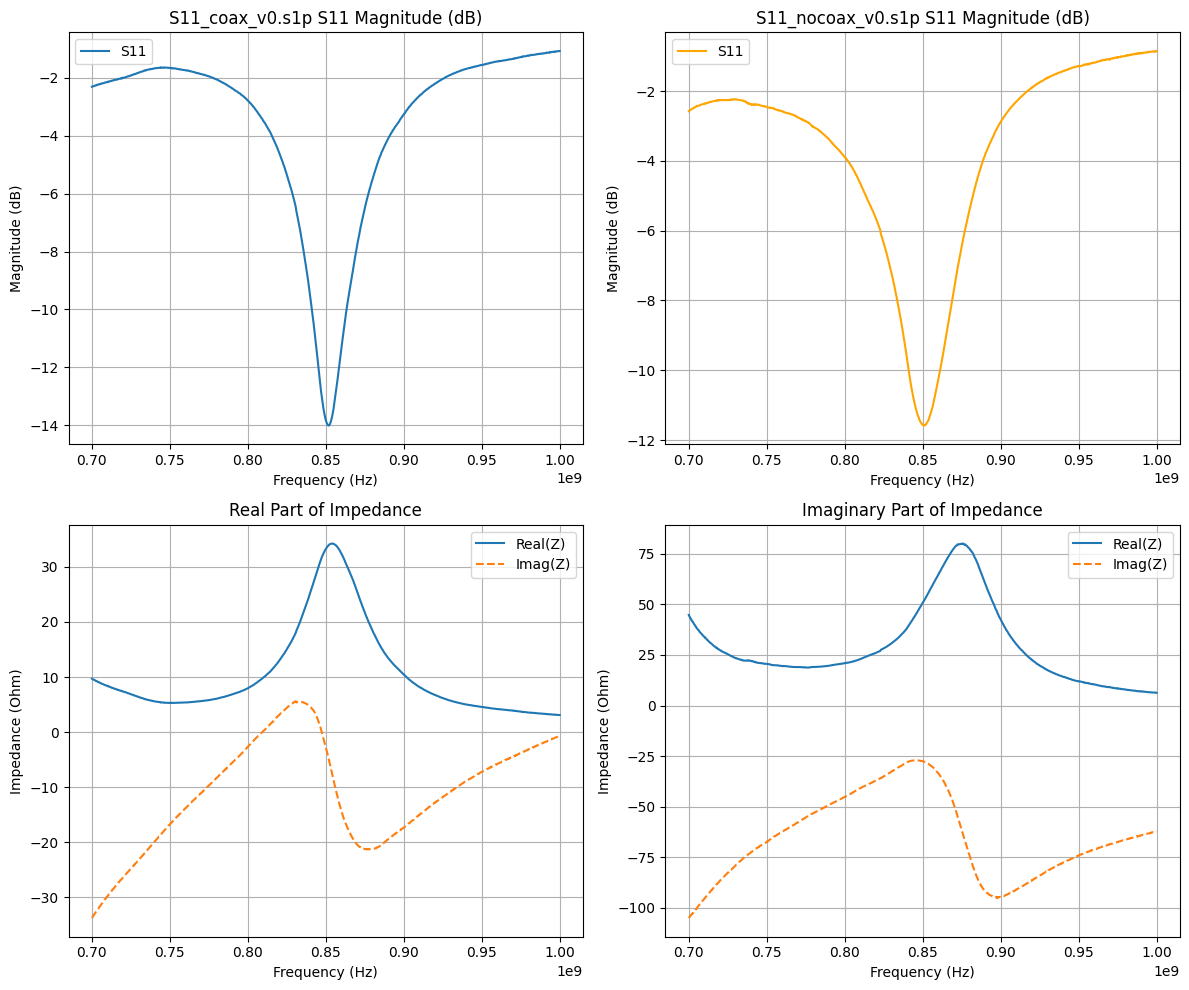

In [20]:
import skrf as rf
import numpy as np
import matplotlib.pyplot as plt
import os

# Replace these with the paths to your S1P files
folder = 'data'
file1 = 'S11_coax_v0.s1p'
filepath1 = os.path.join(folder, file1)
file2 = 'S11_nocoax_v0.s1p'
filepath2 = os.path.join(folder, file2)

# Read the two S1P files
ntw1 = rf.Network(filepath1)
ntw2 = rf.Network(filepath2)

# Extract frequency arrays from each file (assumed to be similar or identical)
freq1 = ntw1.frequency.f
freq2 = ntw2.frequency.f

# Extract the S11 parameter for each network (S1P files only contain one port)
s11_1 = ntw1.s[:, 0, 0]
s11_2 = ntw2.s[:, 0, 0]

# Convert S11 magnitude to dB
s11_1_db = 20 * np.log10(np.abs(s11_1))
s11_2_db = 20 * np.log10(np.abs(s11_2))

# Compute the impedance for each network using the built-in z attribute
z1 = ntw1.z[:, 0, 0]
z2 = ntw2.z[:, 0, 0]

# Create a 2x2 grid of subplots
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# Top Left: S11 magnitude for file1
axs[0, 0].plot(freq1, s11_1_db, label=f'S11')
axs[0, 0].set_title(f'{file1} S11 Magnitude (dB)')
axs[0, 0].set_xlabel('Frequency (Hz)')
axs[0, 0].set_ylabel('Magnitude (dB)')
axs[0, 0].grid(True)
axs[0, 0].legend()

# Top Right: S11 magnitude for file2
axs[0, 1].plot(freq2, s11_2_db, label='S11', color='orange')
axs[0, 1].set_title(f'{file2} S11 Magnitude (dB)')
axs[0, 1].set_xlabel('Frequency (Hz)')
axs[0, 1].set_ylabel('Magnitude (dB)')
axs[0, 1].grid(True)
axs[0, 1].legend()

# Bottom Left: Real impedance overlaid for both files
axs[1, 0].plot(freq1, np.real(z1), label='Real(Z)')
axs[1, 0].plot(freq2, np.imag(z1), label='Imag(Z)', linestyle='--')
axs[1, 0].set_title('Real Part of Impedance')
axs[1, 0].set_xlabel('Frequency (Hz)')
axs[1, 0].set_ylabel('Impedance (Ohm)')
axs[1, 0].grid(True)
axs[1, 0].legend()

# Bottom Right: Imaginary impedance overlaid for both files
axs[1, 1].plot(freq1, np.real(z2), label='Real(Z)')
axs[1, 1].plot(freq2, np.imag(z2), label='Imag(Z)', linestyle='--')
axs[1, 1].set_title('Imaginary Part of Impedance')
axs[1, 1].set_xlabel('Frequency (Hz)')
axs[1, 1].set_ylabel('Impedance (Ohm)')
axs[1, 1].grid(True)
axs[1, 1].legend()

plt.tight_layout()
plt.show()



### Observations
The measurements were calibrated the same way, however a small connector had to be added for calibration.
This probably shifted the reference plane.
- The [Simualted impedance results](../../simulations/antenna_design/monopole/impedance.pdf) were pretty different from the actual measured antenna.
- It seems like I should have simulated everything with the stitched ground planes as well, instead of expecting it to have minor effect on the simulation.

Note: the impedance seen in the simulation folder assumes a feed impedance of 50 ohms, which isn't our feed impedance.

### Next
- Redo the simulation WITH a stitched ground plane.
- Remove the matching circuit, solder, and check the results without a matching circuit and compare it to the antenna simulation.
- Check the results.